In [1]:
data = '/content/drive/My Drive/Interview/Exposys/LabelledData (1).txt'

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Add a length column for visualization purposee

In [3]:
df = pd.read_table(data,  sep = ',,,',names=['text','label'],index_col=False)
df['length'] = df['text'].apply(len)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df.head()

,text,label,length
0,how did serfdom develop in and then leave russ...,unknown,51
1,what films featured the character popeye doyle ?,what,49
2,how can i find a list of celebrities ' real na...,unknown,52
3,what fowl grabs the spotlight after the chines...,what,69
4,what is the full form of .com ?,what,32


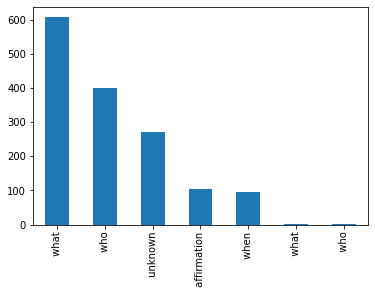

In [5]:
df.label.value_counts().plot(kind='bar')

Some have white spaces so remove them

In [6]:
df.label = df.label.str.strip()

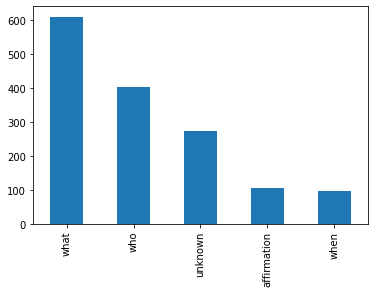

In [7]:
df.label.value_counts().plot(kind='bar')

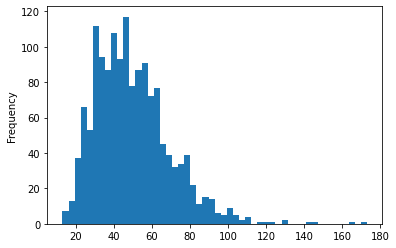

In [8]:
df['length'].plot(bins=50, kind='hist')

In [9]:
from sklearn.preprocessing import LabelEncoder as le
print(df.describe())

            length
count  1483.000000
mean     49.689144
std      19.692057
min      13.000000
25%      35.000000
50%      47.000000
75%      60.000000
max     173.000000


In [10]:

df['label'].unique()

array(['unknown', 'what', 'when', 'who', 'affirmation'], dtype=object)

In [11]:
label_encoder = le()
df['labels']= label_encoder.fit_transform(df['label']) 

df['labels'].unique()

array([1, 2, 3, 4, 0])

Max length is around 170

In [12]:
classes = {0:'affirmation',1:'unknown',2:'what',3:'when',4:'who'}

In [13]:
classes[0]

'affirmation'

In [14]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
import nltk
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfTransformer as TF
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import MultinomialNB as MB
from sklearn.pipeline import Pipeline
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
pt = PorterStemmer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Expect question words such as "what,when" make a list of removable stopwords

In [15]:
questions = ['what', 'which', 'who', 'whom','when', 'where', 'why', 'how', 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop_words = [ i for i in stopwords.words('english') if i not in questions]
print(len(stop_words))

159


Create a simple preprocess function

In [16]:
def text_p(mess):
    nopunc = [x for x in mess if x not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [pt.stem(w) for w in nopunc.split() if w.lower() not in stop_words]

use countvectorizer and pass it to multinomial naive bayes model


In [17]:
nb = Pipeline([('vect', CV()),
               ('clf', MB()),
              ])

In [18]:
X = df['text']
Y = df['label']
X_train, X_test, y_train, y_test = tts(X, Y, random_state = 42, test_size = 0.15)

In [19]:
labels = list(df.label.value_counts().index)

In [20]:
labels

['what', 'who', 'unknown', 'affirmation', 'when']

In [21]:
nb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.8699551569506726
              precision    recall  f1-score   support

        what       0.88      0.50      0.64        14
         who       0.91      0.71      0.80        42
     unknown       0.79      0.99      0.88        86
 affirmation       1.00      0.38      0.56        13
        when       0.96      0.99      0.97        68

    accuracy                           0.87       223
   macro avg       0.91      0.71      0.77       223
weighted avg       0.88      0.87      0.86       223



Clearly our model did somewhat better on "when" but faile when comes to what and affirmation.

Use a logistic regression classifier

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CV(analyzer = text_p,ngram_range=[0,2])),
                ('clf', LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

def get_top_k_predictions(model,X_test,k):
    probs = model.predict_proba(X_test)
    best_n = np.argsort(probs, axis=1)[:,-k:]
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    return preds
 

[LibLinear]accuracy 0.9641255605381166
              precision    recall  f1-score   support

        what       0.93      1.00      0.97        14
         who       1.00      0.93      0.96        42
     unknown       0.94      0.99      0.97        86
 affirmation       0.91      0.77      0.83        13
        when       0.99      0.99      0.99        68

    accuracy                           0.96       223
   macro avg       0.95      0.93      0.94       223
weighted avg       0.96      0.96      0.96       223



Now clearly we have almost every f1-score around > 0.95 except for affirmation.
Here, we are not capturing sequential info but only relying on words.
Let's see more about that

In [24]:

test = df[df['label']=='unknown'].text.head(10)
test

0     how did serfdom develop in and then leave russ...
2     how can i find a list of celebrities ' real na...
9     name the scar-faced bounty hunter of the old w...
11     why do heavier objects travel downhill faster ? 
17    how many jews were executed in concentration c...
22                            name 11 famous martyrs . 
28                name a golf course in myrtle beach . 
29           which two states enclose chesapeake bay ? 
32    how many points make up a perfect fivepin bowl...
33    which company that manufactures video-game har...
Name: text, dtype: object

In [25]:


get_top_k_predictions(logreg,test,2)

[['unknown', 'when'],
 ['unknown', 'when'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation'],
 ['unknown', 'affirmation']]

In [26]:
text = df[df['label']=='when'].head(30).text
org = ['when' for i in range(30)]
pp = logreg.predict(text)

In [27]:
predictions = pd.DataFrame({'text': text, 'Original_label': org,'predicted_label' : pp})

In [28]:
predictions

,text,Original_label,predicted_label
10,when was ozzy osbourne born ?,when,when
36,when did the neanderthal man live ?,when,when
90,when did cnn begin broadcasting ?,when,when
203,when did the royal wedding of prince andrew an...,when,when
228,when did beethoven die ?,when,when
250,when was the first steel mill in the united st...,when,when
260,when did mount st. helen last have a significa...,when,when
262,when did world war i start ?,when,when
279,when was the battle of the somme fought ?,when,when
282,when did spielberg direct `` jaws '' ?,when,when


In [29]:
logreg.predict(['when are sheep shorn ?'])

array(['when'], dtype=object)


The model did well in this case but mostly due to the unique word in those two questions starting with what

For better meaningfull classification we should do
***Bidirectional LSTM with word embeddings***
Because lstm is a sequential model that can remember long term dependencies and also embeddings are better way of representing words. Like similar words are grouped together through embeddings.

In [30]:
df.label.value_counts()

what           609
who            402
unknown        272
affirmation    104
when            96
Name: label, dtype: int64

In [31]:
import numpy as np 
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


import os

Using TensorFlow backend.


In [32]:
df

,text,label,length,labels
0,how did serfdom develop in and then leave russ...,unknown,51,1
1,what films featured the character popeye doyle ?,what,49,2
2,how can i find a list of celebrities ' real na...,unknown,52,1
3,what fowl grabs the spotlight after the chines...,what,69,2
4,what is the full form of .com ?,what,32,2
...,...,...,...,...
1478,can it be cut to fit ?,affirmation,23,0
1479,can it be removed ?,affirmation,20,0
1480,does this hose have one ?,affirmation,26,0
1481,can i get it in india ?,affirmation,24,0


In [33]:
df.label.value_counts()

what           609
who            402
unknown        272
affirmation    104
when            96
Name: label, dtype: int64

In [34]:
df['class_name'] = 0
df.loc[df['label'] == 'unknown', 'class_name'] = 0
df.loc[df['label'] == 'what', 'class_name'] = 1
df.loc[df['label'] == 'when', 'class_name'] = 2
df.loc[df['label'] == 'who', 'class_name'] = 3
df.loc[df['label'] == 'affirmation', 'class_name'] = 3
print(df['class_name'][:5])
labels = to_categorical(df['class_name'], num_classes=5)
print(labels[:4])
if 'label' in df.keys():
    df.drop(['label'], axis=1)

0    0
1    1
2    0
3    1
4    1
Name: class_name, dtype: int64
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [35]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [36]:
n_most_common_words = 2000
max_len = 170
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
sequences = tokenizer.texts_to_sequences(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 3675 unique tokens.


In [37]:
 embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/My Drive/NLP/Embeddings/GLOVE/glove.txt',tokenizer.word_index, embedding_dim)

In [38]:
vocab_size = len(tokenizer.word_index) + 1  
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements/vocab_size

0.9806855277475517

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.15, random_state=42)

In [40]:
epochs = 30
batch_size = 32
labels[:2]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [42]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=170,trainable=False))
model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, dropout=0.7, recurrent_dropout=0.7,return_sequences=True)))
model.add(LSTM(32))
model.add(Dense(20,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((1260, 170), (1260, 5), (223, 170), (223, 5))
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 170, 50)           183800    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 170, 50)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 170, 128)          58880     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 105       
Total params: 264,053
Trainable params: 80,253
Non-trainable params: 183,

In [43]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=170,trainable=True))
model1.add(SpatialDropout1D(0.7))
model1.add(Bidirectional(LSTM(64, dropout=0.7, recurrent_dropout=0.7,return_sequences=True)))
model1.add(LSTM(32))
model1.add(Dense(20,activation='relu'))
model1.add(Dense(5, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model1.summary())
history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((1260, 170), (1260, 5), (223, 170), (223, 5))
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 170, 50)           183800    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 170, 50)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 170, 128)          58880     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                660       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 105       
Total params: 264,053
Trainable params: 264,053
Non-trainable params: 0
_

In [44]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr1 = model1.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

223/223 [==============================] - 1s 3ms/step
Test set
  Loss: 0.684
  Accuracy: 0.717
223/223 [==============================] - 1s 3ms/step
Test set
  Loss: 0.684
  Accuracy: 0.717


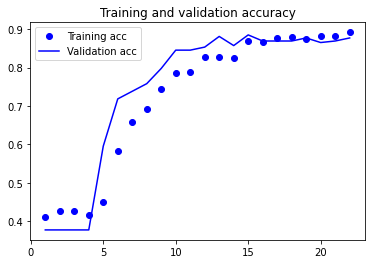

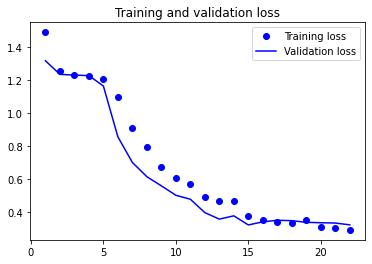

In [78]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [45]:
txt = ["can i eat ?"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['unknown', 'what', 'when', 'who','affirmation']
print(pred, labels[np.argmax(pred)])

[[1.2997484e-01 2.1684241e-01 2.3713519e-01 4.1568887e-01 3.5865625e-04]] who


In [46]:
txt = ["can i eat ?"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model1.predict(padded)
labels = ['unknown', 'what', 'when', 'who','affirmation']
print(pred, labels[np.argmax(pred)])

[[1.6118059e-01 1.4193811e-02 8.3961561e-02 7.4057835e-01 8.5735388e-05]] who


In [47]:
preds = model.predict(X_test)
preds = (preds > 0.5)
preds1 = model1.predict(X_test)
preds1 = (preds1 > 0.5)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))
print(classification_report(y_test,preds1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.78      0.91      0.84        86
           2       0.00      0.00      0.00        13
           3       0.79      0.83      0.81        82
           4       0.00      0.00      0.00         0

   micro avg       0.78      0.65      0.71       223
   macro avg       0.31      0.35      0.33       223
weighted avg       0.59      0.65      0.62       223
 samples avg       0.65      0.65      0.65       223

              precision    recall  f1-score   support

           0       0.97      0.76      0.85        42
           1       0.96      0.99      0.97        86
           2       1.00      0.08      0.14        13
           3       0.87      0.98      0.92        82
           4       0.00      0.00      0.00         0

   micro avg       0.92      0.89      0.90       223
   macro avg       0.76      0.56      0.58       223
weighted avg       0.93

In [92]:
def predict_sentences(s):
    seq = tokenizer.texts_to_sequences(s)
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model1.predict(padded)
    labels = ['unknown', 'what', 'when', 'who','affirmation']
    preds = [labels[i] for i in np.argmax(pred,1)]
    return preds

In [93]:
a = predict_sentences(['who are you?','what time does the train leave?','when is the match?'])

In [94]:
a

['who', 'what', 'who']